    Inés Fuai Guillén Peña      100495752

    Salvador Ayala Iglesias     100495832

En este **primer notebook** hemos desarrollado todo el proceso necesario para abordar el problema de clasificación propuesto. 

El primer paso ha sido realizar un **Análisis Exploratorio de los Datos (EDA)**, donde hemos examinado la estructura del dataset, el número de variables y observaciones, el tipo de variables y la existencia de valores faltantes, columnas constantes o identificadores. Además, hemos comprobado si la variable objetivo está desbalanceada.

A continuación, hemos definido la **estrategia de evaluación**. Para estimar el rendimiento futuro del modelo hemos empleado una partición *holdout* (2/3 para entrenamiento y 1/3 para test).

Seguidamente, hemos evaluado dos modelos básicos: **KNN** y **árboles de decisión**. Primero hemos probado con sus hiperparámetros por omisión y después los hemos ajustado. Estos modelos también nos han servido para decidir los mejores métodos de imputación y escalado a usar.

En la siguiente sección hemos considerado modelos más avanzados, concretamente la **regresión logística (con y sin regularización L1)** y **SVM**.

Finalmente, tras comparar todos los modelos, hemos seleccionado la mejor alternativa en función de su rendimiento durante la evaluación interna y, posteriormente, hemos guardado el modelo final completo en un archivo *.pkl* para su uso posterior en la predicción sobre los datos de la competición.

Durante todo el trabajo, hemos ido documentando cada paso y el porqué de las decisiones elegidas, incluyendo gráficos. 
Además, para algunas tareas puntuales como la organización del código o la generación de gráficos se ha hecho uso de herramientas como ChatGPT, que han servido de apoyo durante el desarrollo del proyecto.

# 2. EDA SIMPLIFICADO

In [144]:
import pandas as pd
import matplotlib.pyplot as plt

Antes de nada, cargamos los datos del archivo *attrition_availabledata_07.csv* y lo mostramos por pantalla usando las funciones *info()* y *head()*.

In [145]:
# cargamos el archivo de datos disponibles
file_path = "attrition_availabledata_07.csv"

df = pd.read_csv(file_path) # leemos el archivo
df.info(), df.head() # mostramos información general del dataset

print("\nValores faltantes por columna:")
print(df.isnull().sum()) # esta función nos sirve para diferenciar las variables con valores faltantes

# detectamos las columnas constantes
constant_columns = [col for col in df.columns if df[col].nunique() == 1]
print("Columnas constantes:", constant_columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2940 non-null   float64
 1   absences                 2940 non-null   int64  
 2   JobInvolvement           2940 non-null   int64  
 3   PerformanceRating        2940 non-null   int64  
 4   EnvironmentSatisfaction  2920 non-null   float64
 5   JobSatisfaction          2924 non-null   float64
 6   WorkLifeBalance          2916 non-null   float64
 7   Age                      2940 non-null   int64  
 8   BusinessTravel           2940 non-null   object 
 9   Department               2940 non-null   object 
 10  DistanceFromHome         2940 non-null   int64  
 11  Education                2940 non-null   int64  
 12  EducationField           2940 non-null   object 
 13  EmployeeCount            2940 non-null   int64  
 14  EmployeeID              

Como podemos ver, el conjunto de datos cuenta con un total de **2940 instancias** y **31 variables**, de las cuales podemos diferenciar que 8 son categóricas y 23 son numéricas. 

En cuanto a la calidad de los datos, hemos identificado varias variables con valores faltantes. Las variables afectadas son:
- *EnvironmentSatisfaction* (20 valores faltantes)
- *JobSatisfaction* (16 valores faltantes)
- *WorkLifeBalance* (24 valores faltantes)
- *NumCompaniesWorked* (15 valores faltantes)
- *TotalWorkingYears* (7 valores faltantes) 

Además, existen posibles columnas irrelevantes dentro del conjunto de datos: las variables **EmployeeCount, Over18** y **StandardHours** son constantes, lo que significa que no aportan información útil para el análisis. Asimismo, **EmployeeID** es un identificador único que no contribuye al modelo de predicción, por lo que lo podriamos eliminar.  

A continuación, exploraremos las variables numéricas para poder saber si existe alguna variable ordinal. 

In [146]:
# seleccionamos solo las columnas numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# aplicamos value_counts a cada variable numérica
print("\nDistribución de las variables numéricas:")
for col in numeric_cols:
    print(f"\n{df[col].value_counts(dropna=False).sort_index()}")



Distribución de las variables numéricas:

hrs
5.416880     1
5.430426     1
5.456191     1
5.461962     1
5.465741     1
            ..
10.869733    1
10.881058    1
10.881625    1
10.903669    1
10.907255    1
Name: count, Length: 2938, dtype: int64

absences
1       5
2      25
3      56
4     106
5     131
6     172
7     167
8     157
9     138
10    163
11    145
12    160
13    143
14    165
15    154
16    155
17    171
18    167
19    169
20    148
21    120
22     77
23     39
24      7
Name: count, dtype: int64

JobInvolvement
1     165
2     724
3    1760
4     291
Name: count, dtype: int64

PerformanceRating
3    2497
4     443
Name: count, dtype: int64

EnvironmentSatisfaction
1.0    571
2.0    575
3.0    888
4.0    886
NaN     20
Name: count, dtype: int64

JobSatisfaction
1.0    593
2.0    559
3.0    868
4.0    904
NaN     16
Name: count, dtype: int64

WorkLifeBalance
1.0     157
2.0     670
3.0    1795
4.0     294
NaN      24
Name: count, dtype: int64

Age
18     15
19 

Tras haber realizado el *value_counts* sobre estas columnas, podemos decir que sí que existen variables ordinales, las cuales son:
- *JobInvolvement*
- *PerformanceRating*
- *EnvironmentSatisfaction*
- *JobSatisfaction*
- *WorkLifeBalance*
- *Education*
- *JobLevel*
- *StockOptionLevel*
- *TrainingTimesLastYear*

Tras esta evaluación, nos encontramos con **8 variables categóricas**, **14 variables numéricas** y **9 variables ordinales**

El hecho de que *Attrition* sea una variable categórica con solo dos valores posibles (*Yes/No*) es lo que define este problema como uno de **CLASIFICACION binaria**. Esto nos dice que el objetivo es clasificar a los empleados en dos grupos (aquellos que se van y aquellos que no se van) en lugar de predecir un valor numérico, lo cual sería típico en un problema de regresión.


Ahora evaluaremos la variable **Attrition** para saber si se trata de un dataset desbalanceado o no.


Distribución de la variable 'Attrition':
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


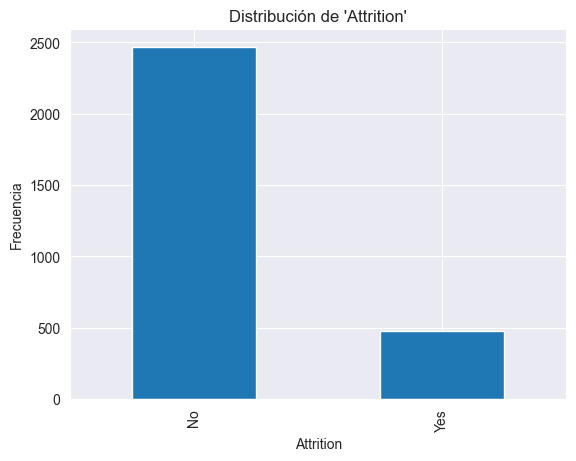

In [147]:
# analizamos la distribución de 'Attrition' para comprobar si está desbalanceado o no
attrition_counts = df["Attrition"].value_counts(normalize=True) * 100
print("\nDistribución de la variable 'Attrition':")
#df['Attrition'].value_counts().head(10).plot(kind='bar')
print(attrition_counts)

df['Attrition'].value_counts().plot(kind='bar', title="Distribución de 'Attrition'")
plt.xlabel('Attrition')
plt.ylabel('Frecuencia')
plt.show()

Al analizar la variable objetivo **Attrition**, que indica si un empleado ha abandonado la empresa (Yes/No), observamos un desequilibrio evidente en las clases. Como muestra la gráfica, la mayoría de los registros pertenecen a la clase "No" mientras que la clase "Yes" representa un porcentaje mucho menor del total.

# 3. CÓMO SE VA A REALIZAR LA EVALUACIÓN

En esta siguiente parte, realizaremos la **evaluación externa**, también conocida como **outer evaluation**.

Primero, tenemos que importar la libreria que necesitamos para usar la función que nos permite hacer la division de los datos en dos conjuntos: *test* y *train*.

Para usar dicha función (*train_test_split*), usaremos los siguientes argumentos:

- **X**: Es un *DataFrame* que contiene todas las columnas del dataset excepto aquellas que no son relevantes para el modelo, es decir, todas aquellas columnas sin contar con *Attrition*, *EmployeeCount*, *Over18* y *StandardHours*

- **y**: Se define la variable objetivo *y* como la columna *Attrition*. Dado que esta columna tiene valores categóricos, realizamos una transformación utilizando la función *map* para convertir estos valores a numéricos: 1 para "Yes" y 0 para "No". Esta conversión es necesaria porque los modelos de aprendizaje automático requieren que las etiquetas sean numéricas.

In [148]:
from sklearn.model_selection import train_test_split

# separamos las características (X) y variable objetivo (y)
X = df.drop(columns=['Attrition', 'EmployeeCount', 'Over18', 'StandardHours'])  # Eliminar la variable objetivo
y = df['Attrition'].map({'Yes': 1, 'No': 0})  # convertimos a valores numéricos

# 1. División en train (2/3) y test (1/3), evaluacion outer
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, shuffle=True, stratify=y, random_state=42)

print("Tamaño total:", len(X))
print("Train:")
print(f" X_train: {X_train.shape}")
print(f" y_train distribución:\n{y_train.value_counts(normalize=True)}\n")

print("Test:")
print(f" X_test: {X_test.shape}")
print(f" y_test distribución:\n{y_test.value_counts(normalize=True)}")

Tamaño total: 2940
Train:
 X_train: (1960, 27)
 y_train distribución:
Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64

Test:
 X_test: (980, 27)
 y_test distribución:
Attrition
0    0.838776
1    0.161224
Name: proportion, dtype: float64


El conjunto de datos se ha dividido en dos partes: **entrenamiento (2/3)** y **test (1/3)** utilizando una partición estratificada para asegurar que la distribución de las clases se mantenga en ambos subconjuntos. 

El **conjunto de entrenamiento** (train), que consta de 1960 ejemplos, lo emplearemos a lo largo de todo el proceso de validación y ajuste de los modelos.

Por otro lado, el **conjunto de test**, con 980 ejemplos, lo destinamos a la evaluación final del modelo una vez finalizado el proceso de optimización.

# 4. MÉTODOS BÁSICOS: KNN Y TREES

A lo largo de esta sección, hemos usado la IA ChatGPT para resolver diversos problemas de programación como la depuración de errores en los pipelines de *scikit-learn* y la corrección de problemas con la manipulación de datos. También nos ha ayudado a generar automáticamente fragmentos de código para tareas repetitivas como la construcción de pipelines o la evaluación de modelos. Además, nos dio explicaciones detalladas sobre el uso de funciones y parámetros en bibliotecas, facilitando el entendimiento de los algoritmos utilizados.

In [149]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

En esta sección, hemos llevado a cabo la **selección del mejor método de escalado e imputación** para este problema. 

El **objetivo** es determinar qué combinación de técnicas permite obtener mejores resultados al ser aplicadas dentro de un pipeline de preprocesamiento. Para ello, realizamos una evaluación sistemática utilizando validación cruzada y *balanced accuracy* como métrica principal.

En primer lugar, separamos las columnas en función del tipo de variable que son: *numéricas*, *categóricas* y *ordinales*. Las variables numéricas se agrupan en la lista *num_values*, las categóricas en *cat_values* y las ordinales en *ord_values*.

A continuación, definimos las técnicas que vamos a evaluar. Para el **escalado** consideramos tres opciones: *MinMaxScaler*, *StandardScaler* y *RobustScaler*. En cuanto a la **imputación** de valores nulos, probamos dos estrategias: imputar con la *media* y con la *mediana*.

Para poder realizar la optimización, necesitamos inicializar las variables *best_score*, *best_scaler* y *best_imputer*, que nos servirán para guardar la mejor puntuación obtenida durante el proceso, el mejor escalado y la mejor imputación respectivamente.

En cuanto a la **evaluación**, empleamos validación cruzada estratificada con *StratifiedKFold* y cinco particiones. Esta técnica nos asegura que en cada pliegue la proporción de clases en la variable objetivo se mantenga, lo cual es especialmente importante dado que el conjunto de datos está desbalanceado.

Construimos un bucle que recorre todas las combinaciones posibles entre las técnicas de escalado e imputación. Para cada combinación, montamos un pipeline que aplica el preprocesamiento correspondiente a cada grupo de variables:
- Las numéricas pasan por un imputador seguido del escalador
- Las categóricas por un imputador y un codificador OneHot
- Las ordinales por un imputador seguido de un codificador Ordinal.

Luego, entrenamos un **modelo KNN** utilizando ese pipeline y evaluamos mediante validación cruzada.

En cada iteración, si la puntuación media obtenida es superior al valor almacenado en *best_score*, actualizamos tanto esta variable como las correspondientes al mejor escalador e imputador encontrados hasta el momento.

Finalmente, una vez recorrido todo el espacio de combinaciones posibles, imprimimos los mejores resultados obtenidos, es decir, qué técnica de escalado y qué imputación proporcionan el mejor rendimiento al modelo KNN según la evaluación interna.

In [150]:
# separacion de columnas
# numéricas
num_values = ['Age', 'DistanceFromHome', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany']
#categóricas
cat_values = ['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
# ordinales
ord_values = ['JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Education', 'JobLevel', 'StockOptionLevel']

# tecnicas que compararemos
scalings = [MinMaxScaler(), StandardScaler(), RobustScaler()]
imputations = ['mean', 'median']

# definimos las variables para los resultados
best_score = 0
best_scaler = None
best_imputer = None

# evaluacion interna usando validación cruzada estratificada
# usamos validación cruzada estratificada para asegurar que cada partición de datos mantenga la distribución original de las clases
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# este bucle recorre todas las posibles combinaciones posibles de escalado e imputacion
for scaler in scalings:
    for imputation in imputations:
        # pipelines individuales para cada tipo de dato
        num_pipeline = Pipeline([ #numericas
            ('imputer', SimpleImputer(strategy=imputation)),
            ('scaler', scaler)
        ])

        cat_pipeline = Pipeline([ #categoricas
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ])

        ord_pipeline = Pipeline([ #ordinales
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OrdinalEncoder())
        ])

        # combinamos todas las pipelines
        preprocessor = ColumnTransformer([
            ('num', num_pipeline, num_values),
            ('cat', cat_pipeline, cat_values),
            ('ord', ord_pipeline, ord_values)
        ])

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', KNeighborsClassifier())
        ])

        # validación cruzada para evaluar el rendimiento del modelo con la configuración actual
        # utilizamos la métrica 'balanced_accuracy' para manejar desequilibrios en las clases
        scores = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring='balanced_accuracy')
        score_mean = scores.mean() # calculamos media de los resultados obtenidos
        
        print(f"Método {scaler} con imputación {imputation}: \tscore {score_mean}")

        # actualizamos variables
        if score_mean > best_score:
            best_score = score_mean
            best_scaler = scaler
            best_imputer = imputation

print("\n")
print(f"Mejor método: {best_scaler} con imputación {best_imputer}")
print(f"Mejor score (balance accuracy): {best_score}")

Método MinMaxScaler() con imputación mean: 	score 0.5713679896582401
Método MinMaxScaler() con imputación median: 	score 0.5713679896582401
Método StandardScaler() con imputación mean: 	score 0.5845072579715159
Método StandardScaler() con imputación median: 	score 0.5845072579715159
Método RobustScaler() con imputación mean: 	score 0.594160892929218
Método RobustScaler() con imputación median: 	score 0.594160892929218


Mejor método: RobustScaler() con imputación mean
Mejor score (balance accuracy): 0.594160892929218


Tras haber realizado la validación cruzada y evaluado las distintas combinaciones de métodos de escalado e imputación, obtenemos que el mejor método es *RobustScaler* para escalar y la *media* para la imputación de valores nulos.

En este siguiente paso vamos a crear el preprocesador final utilizando la mejor combinación de técnicas de escalado e imputación obtenidas previamente. 
- Para las características **numéricas**, vamos a utilizar el *RobustScaler* con imputación por *media*, ya que esta combinación fue la que dio mejores resultados en las iteraciones anteriores
- Para las variables **categóricas**, mantenemos la imputación por la modalidad más frecuente y la codificación *One-Hot Encoder* para las variables nominales
- Para las variables **ordinales**,  mantenemos la imputación por la modalidad más frecuente y utilizamos la codificación *OrdinalEncoder*

Este **final_preprocessor** se integrará en el pipeline final para procesar las características del conjunto de entrenamiento antes de entrenar los modelos.

In [151]:
# preprocesador final con lo mejor encontrado
# creamos de nuevo el preprocesador con la mejor combinación encontrada
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy=best_imputer)),
    ('scaler', best_scaler)
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

ord_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder())
])

final_preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_values),
    ('cat', cat_pipeline, cat_values),
    ('ord', ord_pipeline, ord_values)
])

En esta sección, llevamos a cabo una primera evaluación comparativa entre dos modelos de clasificación básicos: **K-Nearest Neighbors (KNN)** y **Árboles de Decisión**, ambos utilizando sus hiperparámetros por omisión. El **objetivo** de esta comparación inicial es tener una referencia del rendimiento base de cada algoritmo antes de añadir una posible optimización.

Para ello, primero definimos un diccionario *models* en el que vamos a almacenar los dos clasificadores para después construir un pipeline que incluye tanto el preprocesamiento de los datos como el modelo en cuestión. También definimos dos diccionarios *results* y *times* en donde guardaremos los resultados obtenidos.

A continuación, realizamos una **validación cruzada estratificada** utilizando *cross_val_score*, con la métrica de *balanced accuracy* como criterio de evaluación.

Además de los resultados de precisión balanceada, también medimos el tiempo de ejecución de cada modelo. Esto nos permite no solo comparar la calidad del rendimiento, sino también tener en cuenta el coste computacional de cada algoritmo.

Finalmente, imprimimos los resultados obtenidos para cada modelo, incluyendo tanto el valor medio de balanced accuracy como el tiempo total de entrenamiento y evaluación. Estos datos nos dan una primera idea sobre cuál de los dos algoritmos podría ser más prometedor de cara a una futura optimización de hiperparámetros.


In [152]:
# evaluación de modelos
models = {
    'KNN': KNeighborsClassifier(),
    'Árboles': DecisionTreeClassifier(random_state=42)
}

# diccionarios para almacenar los tiempos y resultados
results = {}
times = {}

# iteramos sobre los modelos definidos en 'models'
for name, model in models.items():
    start = time.time()
    pipeline = Pipeline([
        ('preprocessor', final_preprocessor),
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring='balanced_accuracy')
    results[name] = scores.mean() # almacenamos promedio de los resultados de validacion cruzada
    times[name] = time.time() - start # almacenamos el tiempo transcurrido

print("Resultados de los modelos:")
for name, score in results.items():
    print(f"{name}: {score:.4f} (Balanced Accuracy)")

print("\nTiempos de ejecución de los modelos:")
for name, time_taken in times.items():
    print(f"{name}: {time_taken:.4f} segundos")

Resultados de los modelos:
KNN: 0.5942 (Balanced Accuracy)
Árboles: 0.8184 (Balanced Accuracy)

Tiempos de ejecución de los modelos:
KNN: 0.3841 segundos
Árboles: 0.3613 segundos


Tras haber hecho esta evaluación, podemos observar que el modelo de **Árboles de Decisión** ha obtenido un rendimiento claramente superior en términos de **balanced accuracy** frente al modelo **KNN**. Esto sugiere que, incluso sin ajuste fino, el **árbol de decisión** se adapta mejor a la estructura del conjunto de datos.

En cuanto al **tiempo de ejecución**, ambos modelos presentan un rendimiento muy similar.


A continuación, ajustamos los hiperparámetros de ambos modelos usando **GridSearchCV**. Durante el proceso de optimización de hiperparámetros, utilizamos ChatGPT para comprender mejor las técnicas de ajuste de hiperparámetros como *GridSearchCV* y sus ventajas para encontrar los mejores valores para los parámetros de los modelos.

En el caso de **KNN**:

- Definimos un rango de valores para el número de vecinos (*n_neighbors*), evaluando los valores 2 al 28, con un np.arrange. Estos valores fueron seleccionados para explorar una variedad de configuraciones, tanto para valores pequeños como más grandes de vecinos. 

- Distintas opciones para el parámetro *weights*: *uniforme* y *distancia*

- Tres *métricas* de distancia: *minkowski*, *euclidean* y *manhattan*.

En el caso de **Árboles de Decisión**:

- Ajustamos la profundidad máxima del árbol (*max_depth*), evaluando los valores del 2 al 28, con un np.arrange

- El criterio de división (*criterion*), probando tanto *gini* como *entropy*

- El número mínimo de muestras necesarias para realizar una división (*min_samples_split*), con los valores 2, 5 y 10. Estos valores fueron elegidos para explorar diferentes configuraciones en términos de la complejidad del árbol, sin elevar innecesariamente el tiempo necesario para evaluar las opciones.

Para cada combinación de hiperparámetros, utilizamos **GridSearchCV** con validación cruzada (5 particiones) para encontrar los mejores parámetros. 

Los resultados del ajuste de los modelos los almacenamos en las listas *knn_scores* y *dt_scores*, mientras que los tiempos de ejecución se guardan en *knn_times* y *dt_times*. Al final, mostramos la mejor configuración de hiperparámetros y el rendimiento correspondiente para cada modelo, así como el tiempo de entrenamiento.

In [153]:
inner_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# definimos los espacios de búsqueda para GridSearchCV
knn_param_grid = {
    'model__n_neighbors': np.arange(2, 30, 2),
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['minkowski', 'euclidean', 'manhattan']
}

dt_param_grid = {
    'model__max_depth': np.arange(2, 30, 2),
    'model__criterion': ['gini', 'entropy'],
    'model__min_samples_split': [2, 5, 10]
}

# guardamos los resultados aqui
knn_scores = []
knn_times = []
dt_scores = []
dt_times = []

# ajustamos hiperparámetros para KNN
knn_pipeline = Pipeline([
    ('preprocessor', final_preprocessor),
    ('model', KNeighborsClassifier())
])
knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, scoring='balanced_accuracy', cv=inner_cv, n_jobs=-1) #n_jobs para paralelizar y que no tarde tanto
start_time = time.time() # para contar el tiempo
knn_grid.fit(X_train, y_train)
time_knn = time.time() - start_time

knn_scores.append(knn_grid.best_score_)
knn_times.append(time_knn)

# Imprimir resultados de KNN
"""print("\nResultados de KNN para cada combinación de hiperparámetros:")
for mean_score, params in zip(knn_grid.cv_results_['mean_test_score'], knn_grid.cv_results_['params']):
    print(f"Parámetros: {params} => Balanced Accuracy: {mean_score:.4f}")
print("\n")"""    


# ajustamos hiperparametros para Árbol de Decisión
dt_pipeline = Pipeline([
    ('preprocessor', final_preprocessor),
    ('model', DecisionTreeClassifier(random_state=42))
])
dt_grid = GridSearchCV(dt_pipeline, dt_param_grid, scoring='balanced_accuracy', cv=inner_cv, n_jobs=-1)
start_time = time.time()
dt_grid.fit(X_train, y_train)
time_dt = time.time() - start_time

dt_scores.append(dt_grid.best_score_)
dt_times.append(time_dt)

# Imprimir resultados de Árbol de Decisión
"""print("\nResultados de Árbol de Decisión para cada combinación de hiperparámetros:")
for mean_score, params in zip(dt_grid.cv_results_['mean_test_score'], dt_grid.cv_results_['params']):
    print(f"Parámetros: {params} => Balanced Accuracy: {mean_score:.4f}")
print("\n")"""

print(f"Mejores parámetros KNN: {knn_grid.best_params_}")
print(f"Balanced Accuracy KNN: {knn_grid.best_score_:.4f}")
print(f"Tiempo de entrenamiento KNN: {time_knn:.2f} segundos")
print("\n")
print(f"Mejores parámetros Árbol: {dt_grid.best_params_}")
print(f"Balanced Accuracy Árbol: {dt_grid.best_score_:.4f}")
print(f"Tiempo de entrenamiento Árbol: {time_dt:.2f} segundos")

Mejores parámetros KNN: {'model__metric': 'manhattan', 'model__n_neighbors': np.int64(6), 'model__weights': 'distance'}
Balanced Accuracy KNN: 0.8216
Tiempo de entrenamiento KNN: 4.28 segundos


Mejores parámetros Árbol: {'model__criterion': 'gini', 'model__max_depth': np.int64(20), 'model__min_samples_split': 2}
Balanced Accuracy Árbol: 0.8190
Tiempo de entrenamiento Árbol: 3.96 segundos


Para evaluar la influencia de los hiperparámetros en el rendimiento de los modelos, realizamos una comparación de diferentes valores para los parametros del **KNN** y del **Árbol de Decisión**.

- En el caso de **KNN**, el valor óptimo para *n_neighbors* resultó ser 6, con el cual se alcanzó la mejor *Balanced Accuracy*. Como mejor *métrica* obtuvimos *manhattan* y de *weights*, *distance*. 

- Para el **Árbol de Decisión**, los mejores resultados se obtuvieron con una *max_depth* de 20. El parámetro *criterion* que nos dio el mejor resultado fue *gini*, y los *min_samples_split*, 2.

A continuación, mostramos las gráficas tanto de **KNN** como de **Árboles de decisión** comparando los resultados obtenidos antes y después de ajustar los hiperparámetros.


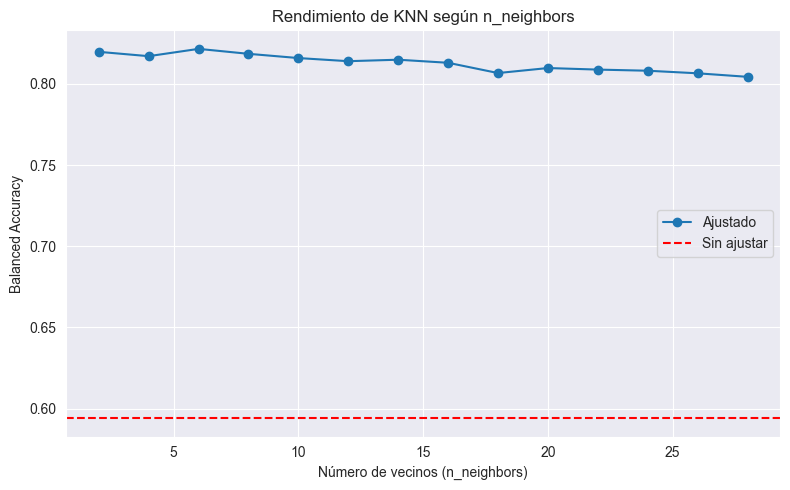

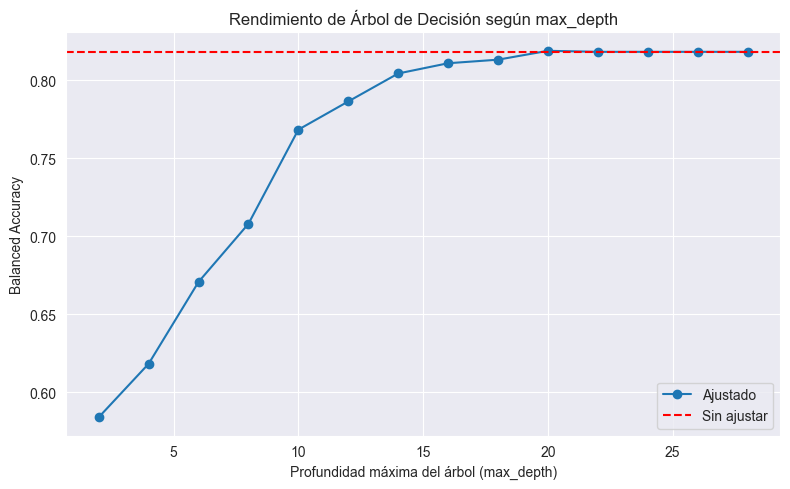

In [154]:
# convertimos los resultados a DataFrame
knn_results = pd.DataFrame(knn_grid.cv_results_)
knn_unadjusted_score = results['KNN']  # ya contiene el balanced accuracy sin ajustar
dt_results = pd.DataFrame(dt_grid.cv_results_)
dt_unadjusted_score = results['Árboles']  

# tomamos los mejores valores de 'weights' y 'metric' según GridSearch
best_weights = knn_grid.best_params_['model__weights']
best_metric = knn_grid.best_params_['model__metric']

# tomamos los mejores valores de los otros hiperparámetros
best_criterion = dt_grid.best_params_['model__criterion']
best_min_samples_split = dt_grid.best_params_['model__min_samples_split']

# filtramos para esos valores y solo cambiamos el número de vecinos 
knn_filtered = knn_results[
    (knn_results['param_model__weights'] == best_weights) &
    (knn_results['param_model__metric'] == best_metric)
][['param_model__n_neighbors', 'mean_test_score']].sort_values('param_model__n_neighbors')

dt_filtered = dt_results[ # cambiamos solo max_depth
    (dt_results['param_model__criterion'] == best_criterion) &
    (dt_results['param_model__min_samples_split'] == best_min_samples_split)
][['param_model__max_depth', 'mean_test_score']].sort_values('param_model__max_depth')

# gráfico 
# KNN
plt.figure(figsize=(8, 5))
plt.plot(knn_filtered['param_model__n_neighbors'], knn_filtered['mean_test_score'], marker='o', label='Ajustado')
plt.axhline(y=knn_unadjusted_score, color='r', linestyle='--', label='Sin ajustar')
plt.xlabel('Número de vecinos (n_neighbors)')
plt.ylabel('Balanced Accuracy')
plt.title('Rendimiento de KNN según n_neighbors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Arboles
plt.figure(figsize=(8, 5))
plt.plot(dt_filtered['param_model__max_depth'], dt_filtered['mean_test_score'], marker='o', label='Ajustado')
plt.axhline(y=dt_unadjusted_score, color='r', linestyle='--', label='Sin ajustar')
plt.xlabel('Profundidad máxima del árbol (max_depth)')
plt.ylabel('Balanced Accuracy')
plt.title('Rendimiento de Árbol de Decisión según max_depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Como vemos, para **KNN** los *balance accuracy* obtenidos tras el ajuste de parametros no tienen un cambio drástico entre sí. A medida que aumentamos el número de vecinos va descendiendo ligeramente. En comparación con lo obtenido sin haber ajustado los hiperparámetros, observamos que ha habido una gran mejora.

Por otro lado, en el gráfico de los **Árboles** podemos observar cómo incrementa el *balance accuracy* a medida que aumentamos el *max_depth*. Esto significa que cuanta mayor profundidad tenga el árbol, mejor serán los resultados obtenidos.

# Tarea adicional

Para abordar el problema del desequilibrio de clases en el conjunto de datos, hemos realizado la tarea adicional de usar **SMOTE** *(Synthetic Minority Over-sampling Technique)*, que es una técnica de sobremuestreo que genera ejemplos sintéticos para la clase minoritaria. 

A diferencia de simplemente replicar los ejemplos existentes, gracias a **SMOTE** creamos nuevas instancias interpolando entre los puntos más cercanos de la clase minoritaria, lo que nos ayuda a evitar el sobreajuste y mantiene la diversidad en los datos. 

Elegimos esta técnica porque está ampliamente respaldada como **efectiva para mejorar el rendimiento de modelos** en escenarios de desequilibrio de clases, especialmente en clasificadores como los **árboles de decisión** o **KNN**, que es nuestro caso. 

Además, solo lo hemos integrado en el pipeline de preprocesamiento de forma que solo se aplica en los conjuntos de entrenamiento durante la validación cruzada, evitando *information leakage* hacia el conjunto de validación y garantizando una evaluación justa del modelo.

In [155]:
# definimos la técnica de balanceo
smote = SMOTE(sampling_strategy='auto', random_state=42)

# guardamos los resultados aquí
knn_scores_smote = []
knn_times_smote = []
dt_scores_smote = []
dt_times_smote = []

# ajustamos hiperparámetros para KNN
knn_pipeline_smote = imPipeline([
    ('preprocessor', final_preprocessor),
    ('smote', smote),
    ('model', KNeighborsClassifier())
])
knn_grid_smote = GridSearchCV(knn_pipeline_smote, knn_param_grid, scoring='balanced_accuracy', cv=inner_cv, n_jobs=-1) #n_jobs para paralelizar y que no tarde tanto
start_time = time.time()  # para contar el tiempo
knn_grid_smote.fit(X_train, y_train)
time_knn = time.time() - start_time

knn_scores_smote.append(knn_grid_smote.best_score_) # guardamos datos
knn_times_smote.append(time_knn)

# ajustamos hiperparámetros para Árbol de Decisión
dt_pipeline_smote = imPipeline([
    ('preprocessor', final_preprocessor),
    ('smote', smote),
    ('model', DecisionTreeClassifier(random_state=42))
])
dt_grid_smote = GridSearchCV(dt_pipeline_smote, dt_param_grid, scoring='balanced_accuracy', cv=inner_cv, n_jobs=-1)
start_time = time.time()
dt_grid_smote.fit(X_train, y_train)
time_dt = time.time() - start_time

dt_scores_smote.append(dt_grid_smote.best_score_) # guardamos datos
dt_times_smote.append(time_dt)

print(f"Mejores parámetros KNN SMOTE: {knn_grid_smote.best_params_}")
print(f"Balanced Accuracy KNN SMOTE: {knn_grid_smote.best_score_:.4f}")
print(f"Tiempo de entrenamiento KNN SMOTE: {time_knn:.2f} segundos")
print("\n")
print(f"Mejores parámetros Árbol SMOTE: {dt_grid_smote.best_params_}")
print(f"Balanced Accuracy Árbol SMOTE: {dt_grid_smote.best_score_:.4f}")
print(f"Tiempo de entrenamiento Árbol SMOTE: {time_dt:.2f} segundos")

Mejores parámetros KNN SMOTE: {'model__metric': 'manhattan', 'model__n_neighbors': np.int64(28), 'model__weights': 'distance'}
Balanced Accuracy KNN SMOTE: 0.8462
Tiempo de entrenamiento KNN SMOTE: 4.55 segundos


Mejores parámetros Árbol SMOTE: {'model__criterion': 'entropy', 'model__max_depth': np.int64(18), 'model__min_samples_split': 2}
Balanced Accuracy Árbol SMOTE: 0.8314
Tiempo de entrenamiento Árbol SMOTE: 5.10 segundos


Con estos resultados, podemos confirmar que **SMOTE**, en efecto, mejora los resultados con respecto a los iniciales.

In [156]:
print("Resultados de los modelos sin ajustar hiperparametros:")
for name, score in results.items():
    print(f"  {name}: {score:.4f} (Balanced Accuracy)")

print("\n")
print(f"Mejores parámetros KNN: {knn_grid.best_params_}")
print(f"Balanced Accuracy KNN ajustando hiperparametros: {knn_grid.best_score_:.4f}, Tiempo de entrenamiento KNN: {time_knn:.2f} segundos")
print(f"Mejores parámetros Árbol: {dt_grid.best_params_}")
print(f"Balanced Accuracy Árbol ajustando hiperparametros: {dt_grid.best_score_:.4f}, Tiempo de entrenamiento Árbol: {time_dt:.2f} segundos")
print("\n")
print(f"Mejores parámetros KNN SMOTE: {knn_grid_smote.best_params_}")
print(f"Balanced Accuracy KNN SMOTE: {knn_grid_smote.best_score_:.4f}, Tiempo de entrenamiento KNN SMOTE: {time_knn:.2f} segundos")
print(f"Mejores parámetros Árbol SMOTE: {dt_grid_smote.best_params_}")
print(f"Balanced Accuracy Árbol SMOTE: {dt_grid_smote.best_score_:.4f}, Tiempo de entrenamiento Árbol SMOTE: {time_dt:.2f} segundos")

Resultados de los modelos sin ajustar hiperparametros:
  KNN: 0.5942 (Balanced Accuracy)
  Árboles: 0.8184 (Balanced Accuracy)


Mejores parámetros KNN: {'model__metric': 'manhattan', 'model__n_neighbors': np.int64(6), 'model__weights': 'distance'}
Balanced Accuracy KNN ajustando hiperparametros: 0.8216, Tiempo de entrenamiento KNN: 4.55 segundos
Mejores parámetros Árbol: {'model__criterion': 'gini', 'model__max_depth': np.int64(20), 'model__min_samples_split': 2}
Balanced Accuracy Árbol ajustando hiperparametros: 0.8190, Tiempo de entrenamiento Árbol: 5.10 segundos


Mejores parámetros KNN SMOTE: {'model__metric': 'manhattan', 'model__n_neighbors': np.int64(28), 'model__weights': 'distance'}
Balanced Accuracy KNN SMOTE: 0.8462, Tiempo de entrenamiento KNN SMOTE: 4.55 segundos
Mejores parámetros Árbol SMOTE: {'model__criterion': 'entropy', 'model__max_depth': np.int64(18), 'model__min_samples_split': 2}
Balanced Accuracy Árbol SMOTE: 0.8314, Tiempo de entrenamiento Árbol SMOTE: 5.10 se

Tras la evaluación de estos resultados, podemos concluir que el modelo con mejor rendimiento ha sido el **KNN**, con una Balanced Accuracy de ligeramente mayor.

En cuanto al ajuste de los hiperparámetros, sin tener en cuenta el **SMOTE**, para **KNN** nos ha dado que un valor de *n_neighbors*=6 es el más eficiente; mientras que, para el **Árbol de Decisión**, ha sido una *max_depth*=20.

Por otro lado, si tenemos en cuenta el **SMOTE**, obtenemos que para **KNN** un valor de *n_neighbors*=28 es el más eficiente; mientras que, para el **Árbol de Decisión**, ha sido una *max_depth*=18.

Estos resultados confirman que el **KNN** es el modelo más adecuado para este conjunto de datos, con un rendimiento superior al **Árbol de Decisión** y un tiempo de ejecución ligeramente más largo.

En términos de **tiempo de ejecución**, ambos modelos fueron relativamente rápidos. KNN tardó más debido a su naturaleza perezosa (*lazy learning*), pero el tiempo de entrenamiento se mantuvo dentro de un rango razonable.

Los resultados son, efectivamente, mejores que los modelos *triviales/naive/dummy*. Al comparar con un modelo **DummyClassifier**, cuyo *balanced_accuracy* típicamente no supera el 0.50, ambos modelos reales obtienen mejores resultados.

El **ajuste de hiperparámetros** ha contribuido a mejorar los resultados con respecto a los valores por omisión. La mejora fue más notable en el caso de KNN:

- En **KNN**, la Balanced Accuracy aumentó de 0.5942 -> 0.8216 -> 0.8462 tras el ajuste del número de vecinos y la inclusión de **SMOTE**.

- En el **Árbol de Decisión**, la mejora fue más sutil: la Balanced Accuracy pasó de 0.8184 -> 0.8190 -> 0.8314 tras ajustar la profundidad máxima del árbol y la inclusión de **SMOTE**.

# 5. AVANZADOS: MODELOS LINEALES Y SVMS

In [157]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from imblearn.pipeline import Pipeline as imPipeline
import time

Para esta parte del análisis, comenzamos creando un diccionario *models* que contiene tres modelos distintos para evaluar su rendimiento: un modelo de **regresión logística con regularización L1 (Lasso)**, un modelo de **regresión logística sin regularización** y un **SVM**.

Una vez definidos los modelos, procedemos a evaluarlos utilizando la **validación cruzada** con la función *cross_val_score*. En este caso, utilizamos **balanced accuracy** como la métrica para evaluar el desempeño, dado que es una métrica adecuada para conjuntos de datos desbalanceados.

Además, medimos los **tiempos de ejecución** de cada modelo, registrando cuánto tiempo tarda cada uno en realizar la validación cruzada. Esto nos permite no solo comparar el rendimiento de los modelos en términos de precisión, sino también en cuanto a eficiencia computacional. 

Los resultados se almacenan en un diccionario llamado *results*, que contiene el valor de balanced accuracy para cada modelo. Además, el tiempo de ejecución se almacena en el diccionario *times* para poder comparar la eficiencia computacional de cada uno.

Finalmente, imprimimos los resultados de las evaluaciones de los modelos, mostrando tanto el **balanced accuracy** como el **tiempo de ejecución** para cada modelo.

In [158]:
# ya habíamos definido previamente el pipeline de preprocesamiento
# num_pipeline, cat_pipeline, ord_pipeline, final_preprocessor
# modelos a evaluar
models = {
    'Logistic Regression (L1)': LogisticRegression(solver='liblinear', penalty='l1', C=0.1),
    'Logistic Regression (sin regularización)': LogisticRegression(solver='liblinear'), # no hay penalty
    'SVM': SVC(kernel='rbf', random_state=42) # rbf porque nos da mejor resultado que si fuese linear
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# resultados y tiempos
results = {}
times = {}

# evaluamos modelos con hiperparámetros por omisión
for name, model in models.items():
    start = time.time()
    pipeline = Pipeline([
        ('preprocessor', final_preprocessor),  # usamos el preprocesador final ya definido
        ('model', model)
    ])
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='balanced_accuracy', error_score='raise')
    results[name] = scores.mean()
    times[name] = time.time() - start

for name in results:
    print(f"{name}: {results[name]:.4f} (Balanced Accuracy), Tiempo: {times[name]:.2f} segundos")

Logistic Regression (L1): 0.5589 (Balanced Accuracy), Tiempo: 0.31 segundos
Logistic Regression (sin regularización): 0.6010 (Balanced Accuracy), Tiempo: 0.33 segundos
SVM: 0.5712 (Balanced Accuracy), Tiempo: 0.95 segundos


Obteniendo estos resultados podemos afirmar que:

- *Regresión Logística (L1)* mostró un rendimiento moderado. El tiempo de entrenamiento fue relativamente bajo, no mejoró sustancialmente el rendimiento en comparación con otros modelos.

- *Regresión Logística (sin regularización)* presenta un rendimiento superior en comparación con la versión L1, lo que indica que este modelo fue más efectivo para clasificar los datos. Además, el tiempo de ejecución fue ligeramente más bajo, lo que muestra una eficiencia comparable al modelo con regularización L1.

- El rendimiento de *SVM* fue inferior a la de la regresión logística sin regularización. El tiempo de ejecución fue el más largo entre los tres modelos evaluados.

De los modelos evaluados, la **Regresión Logística sin regularización** obtuvo el mejor rendimiento, seguida de cerca por el modelo **SVM**. La **Regresión Logística con regularización L1** tuvo el peor desempeño.


A continuación, **ajustamos los hiperparámetros** más importantes y evaluamos de nuevo los modelos.

Para comenzar, definimos el rango de valores para el hiperparámetro C que queremos probar. En este caso, los valores seleccionados son [0.01, 0.1, 1, 10]. Si bien un rango más amplio de valores podría proporcionarnos más precisión, decidimos limitarlo para evitar tiempos de ejecución innecesarios, ya que un ajuste excesivo podría no ser necesario.

Además, incorporamos la técnica **SMOTE** *(Synthetic Minority Over-sampling Technique)* dentro del pipeline para balancear las clases durante el entrenamiento. Luego, utilizamos **GridSearchCV** para realizar una búsqueda exhaustiva sobre los hiperparámetros definidos. Realizamos la busqueda mediante *validación cruzada*.

Durante el proceso, para cada modelo (*regresión logística L1, sin regularizar* y *SVM*), construimos un pipeline que incluye el preprocesamiento de datos y el modelo correspondiente. Posteriormente, medimos el tiempo que toma ajustar cada modelo con GridSearchCV. Los resultados obtenidos, como el mejor *balanced accuracy* y el valor óptimo de *C* las almacenamos en los diccionarios *adjusted_results* y *adjusted_times*.

Finalmente, imprimimos los resultados de los modelos ajustados.

In [159]:
# definimos el rango de valores que queremos probar para el hiperparámetro C
#param_grid = {'model__C': [0.001, 0.01, 0.1, 1, 10, 100]} # añadiendo tantos valores tarda mucho en ejecutarse el codigo
param_grid = {'model__C': [0.01, 0.1, 1, 10]}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# diccionarios para almacenar los resultados y tiempos
adjusted_results = {}
adjusted_times = {}

# evaluación de los modelos con GridSearchCV
for name, model in models.items():
    print(f"\nAjustamos hiperparámetros para {name}")
    
    # creamos el pipeline con el preprocesador y el modelo
    pipeline = imPipeline([
    ('preprocessor', final_preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('model', model)
    ])
    
    # configuramos GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, scoring='balanced_accuracy', cv=cv, n_jobs=-1)
    
    # medimos el tiempo de ajuste
    start = time.time()
    grid_search.fit(X_train, y_train)
    end = time.time()
    
    # almacenamos los resultados
    adjusted_results[name] = grid_search.best_score_
    adjusted_times[name] = end - start
    
    print(f"Mejor valor de C: {grid_search.best_params_['model__C']}")
    print(f"Mejor score (Balanced Accuracy): {grid_search.best_score_:.4f}")
    print(f"Tiempo de entrenamiento: {adjusted_times[name]:.2f} segundos")


Ajustamos hiperparámetros para Logistic Regression (L1)
Mejor valor de C: 1
Mejor score (Balanced Accuracy): 0.7037
Tiempo de entrenamiento: 0.71 segundos

Ajustamos hiperparámetros para Logistic Regression (sin regularización)
Mejor valor de C: 0.01
Mejor score (Balanced Accuracy): 0.7119
Tiempo de entrenamiento: 0.35 segundos

Ajustamos hiperparámetros para SVM
Mejor valor de C: 10
Mejor score (Balanced Accuracy): 0.8392
Tiempo de entrenamiento: 1.95 segundos


Ahora, compararemos los resultados obtenidos tras haber realizado la evaluación de los modelos con los hiperparámetros por omisión y tras haberlos ajustado.

In [160]:
print("\nResumen de los modelos sin ajustar:")
for name in results:
    print(f"{name}: {results[name]:.4f} (Balanced Accuracy), Tiempo: {times[name]:.2f} segundos")
    
print("\nResumen de los modelos ajustados:")
for name in adjusted_results:
    print(f"{name}: {adjusted_results[name]:.4f} (Balanced Accuracy), Tiempo: {adjusted_times[name]:.2f} segundos")


Resumen de los modelos sin ajustar:
Logistic Regression (L1): 0.5589 (Balanced Accuracy), Tiempo: 0.31 segundos
Logistic Regression (sin regularización): 0.6010 (Balanced Accuracy), Tiempo: 0.33 segundos
SVM: 0.5712 (Balanced Accuracy), Tiempo: 0.95 segundos

Resumen de los modelos ajustados:
Logistic Regression (L1): 0.7037 (Balanced Accuracy), Tiempo: 0.71 segundos
Logistic Regression (sin regularización): 0.7119 (Balanced Accuracy), Tiempo: 0.35 segundos
SVM: 0.8392 (Balanced Accuracy), Tiempo: 1.95 segundos


A continuación, presentamos los resultados tras el ajuste de los hiperparámetros para los modelos, con el *parámetro C* como el principal ajuste. El valor de C es crucial, ya que controla el grado de regularización aplicado al modelo; un valor pequeño de C implica mayor regularización (mayor penalización a los errores), mientras que un valor grande permite menos regularización (más flexibilidad en el ajuste del modelo).

- **Logistic Regression (L1)**, el mejor valor de C encontrado fue 1. El tiempo de entrenamiento obtenido demuestra que, a pesar de ser un modelo relativamente sencillo, el ajuste de este hiperparámetro requiere un tiempo moderado.

- **Logistic Regression (sin regularización)**, el valor óptimo de C fue 0.01. A pesar de no aplicar regularización en este modelo, un valor bajo de C proporciona un equilibrio adecuado para evitar un sobreajuste. Este rendimiento es ligeramente superior al de la Regresión Logística L1, lo que nos indica que la falta de regularización, combinada con un valor bajo de C, nos ha permitido que el modelo se ajuste mejor a los datos sin caer en sobreajuste. Además, el tiempo de entrenamiento fue el más corto, lo que refleja la eficiencia de este modelo al no aplicar regularización.

- **SVM**, con su valor óptimo de C igual a 10, ha mostrado un rendimiento notablemente superior con respecto a los de regresión lineal. Sin embargo, este ajuste ha requerido más tiempo de entrenamiento, lo que refleja la mayor complejidad de este modelo y su mayor demanda computacional. A pesar de este tiempo mayor, los resultados obtenidos justifican el esfuerzo, ya que el SVM superó con creces a los otros modelos en términos de precisión.

Los **tiempos de entrenamiento** de los modelos con hiperparámetros ajustados son razonablemente mayores que con los hiperparámetros por omisión, esto se debe principalmente al proceso de búsqueda de los valores óptimos de C mediante validación cruzada.


En resumen, los resultados del ajuste de hiperparámetros han mostrado que el **SVM** con C=10 ofrece el mejor rendimiento, seguido por la **Regresión Logística (sin regularización)** con C=0.01. La **Regresión Logística L1** también presenta un buen rendimiento, aunque ligeramente inferior al de los otros modelos.
 
Estos resultados son importantes, ya que nos permiten entender qué configuraciones de parámetros son más adecuadas para los modelos en función de las características del conjunto de datos y los objetivos del análisis.

# Técnicas para identificar atributos relevantes
Existen **técnicas** que nos permiten identificar **qué atributos son los más relevantes** en un modelo predictivo. 

- Una de las más destacadas es la **Regresión Logística con regularización L1 (Lasso)**, que utiliza una penalización en los coeficientes de las variables. Esta regularización tiende a reducir a cero los coeficientes de aquellas variables que no aportan información relevante al modelo y como resultado, cualquier atributo cuyo coeficiente sea diferente de cero se considera relevante para la predicción.

- Por otro lado, la **Regresión Logística sin regularización** también nos permite observar los coeficientes de las variables, pero a diferencia de la *técnica Lasso*, no fuerza la eliminación de variables irrelevantes. En este caso, todos los coeficientes serán diferentes de cero, aunque algunos puedan ser muy pequeños.

- En cuanto a las **máquinas de vectores de soporte (SVM)**, es importante tener en cuenta que solo el **SVM con kernel lineal** permite interpretar los coeficientes de manera directa. Esto se debe a que, en modelos SVM con kernel no lineales (como el RBF), no se generan coeficientes interpretables de forma directa. Por lo tanto, si queremos obtener información sobre la relevancia de las características en el SVM, debemos asegurarnos de utilizar un SVM lineal. 

Para ello debemos tener en cuenta que cuanto mayor es el valor absoluto de un coeficiente, mayor será la influencia de esa variable en la predicción. Además, el signo del coeficiente indica si su impacto con la clase objetivo es positiva o negativa.

Durante este análisis, hicimos uso de ChatGPT para comprender mejor cómo interpretar los coeficientes y cómo ajustar la regularización para mejorar la capacidad predictiva del modelo. También fue útil para entender la diferencia entre los resultados obtenidos con y sin regularización y cómo esta diferencia puede influir en la interpretación de los coeficientes y la selección de variables.

- - -

Para realizar este proceso, primero construimos **pipelines** para cada modelo, donde combinamos el preprocesamiento de datos y el modelo de aprendizaje automático.
 
- En el caso de la **Regresión Logística con regularización L1** (Lasso), utilizamos un valor de **C=1**, ya que este fue el mejor parámetro obtenido en la validación previa. 

- Para la **Regresión Logística sin regularización**, utilizamos el modelo clásico de regresión logística sin penalización.

- Para el **modelo SVM lineal**, utilizamos el valor **C=10**, que fue el mejor encontrado tras la búsqueda de hiperparámetros.

Una vez definidos y ajustados los modelos, entrenamos cada uno de ellos utilizando el conjunto de entrenamiento. Esto se realiza a través del método *fit()* en cada uno de los pipelines, lo que permite que el modelo aprenda a partir de los datos.

Tras el entrenamiento, extraemos los coeficientes de cada modelo utilizando el atributo *.coef_*, lo que nos permite ver la influencia de cada característica en la predicción.

Para interpretar estos coeficientes y entender la relevancia de las variables, primero obtenemos los nombres de las características transformadas por el preprocesador utilizando el método *.get_feature_names_out()*. Esto es crucial para poder asociar cada coeficiente con la variable original correspondiente. 

Luego, creamos un dataframe para cada modelo, en el que incluimos tanto los nombres de las características como sus coeficientes. Calculamos también el valor absoluto de los coeficientes, ya que nos permite medir la importancia de cada variable sin tener en cuenta el signo (positivo o negativo) del coeficiente. 

Posteriormente, ordenamos las características en función del valor absoluto de sus coeficientes de mayor a menor, lo que nos permite identificar fácilmente las variables más relevantes para cada modelo.

Finalmente, mostramos las 10 variables más importantes para cada uno de los modelos evaluados.

In [161]:
# pipeline con regularización L1
pipeline_l1 = Pipeline([
    ('preprocessor', final_preprocessor),
    ('model', LogisticRegression(penalty='l1', solver='liblinear', C=1))  # C=1 fue el mejor en validación
])

# pipeline sin regularización
pipeline_logreg_none = Pipeline([
    ('preprocessor', final_preprocessor),
    ('model', LogisticRegression(solver='liblinear', max_iter=1000))  # aumentamos max_iter por si acaso
])

# pipeline SVM
pipeline_svm = Pipeline([
    ('preprocessor', final_preprocessor),
    ('model', SVC(kernel='linear', C=10))  
])

# entrenamos cada pipeline con los datos de entrenamiento
pipeline_l1.fit(X_train, y_train)
pipeline_logreg_none.fit(X_train, y_train)
pipeline_svm.fit(X_train, y_train)

# obtenemos los coeficientes de los modelos
coefficients_l1 = pipeline_l1.named_steps['model'].coef_[0]
coefficients_logreg_none = pipeline_logreg_none.named_steps['model'].coef_[0]
coefficients_svm = pipeline_svm.named_steps['model'].coef_[0]

# obtenemos los nombres de las características (deberían ser los mismos para todos los modelos)
# nos aseguramos que las características sean las mismas después de los preprocesamientos
feature_names_l1 = pipeline_l1.named_steps['preprocessor'].get_feature_names_out()
feature_names_logreg_none = pipeline_logreg_none.named_steps['preprocessor'].get_feature_names_out()
feature_names_svm = pipeline_svm.named_steps['preprocessor'].get_feature_names_out()

# creamos los DataFrame para cada modelo
coef_df_l1 = pd.DataFrame({  # Para el modelo L1
    'feature': feature_names_l1, 
    'coefficient': coefficients_l1
})
coef_df_l1['abs_coef'] = coef_df_l1['coefficient'].abs()
coef_df_l1_sorted = coef_df_l1.sort_values(by='abs_coef', ascending=False)

coef_df_none = pd.DataFrame({  # Para el modelo sin regularizar
    'feature': feature_names_logreg_none,
    'coefficient': coefficients_logreg_none
})
coef_df_none['abs_coef'] = coef_df_none['coefficient'].abs()
coef_df_none_sorted = coef_df_none.sort_values(by='abs_coef', ascending=False)

coef_df_svm = pd.DataFrame({  # Para el modelo SVM lineal
    'feature': feature_names_svm,
    'coefficient': coefficients_svm
})
coef_df_svm['abs_coef'] = coef_df_svm['coefficient'].abs()
coef_df_svm_sorted = coef_df_svm.sort_values(by='abs_coef', ascending=False)

print("Top 10 variables más importantes (Regresión L1):")
print(coef_df_l1_sorted.head(10))  # Mostramos las 10 variables más importantes para L1
print("\n")
print("Top 10 variables más importantes (Regresión sin regularización):")
print(coef_df_none_sorted.head(10))  # Mostramos las 10 variables más importantes para LogReg sin regularización
print("\n")
print("Top 10 variables más importantes (SVM):")
print(coef_df_svm_sorted.head(10))  # Mostramos las 10 variables más importantes para SVM

Top 10 variables más importantes (Regresión L1):
                                  feature  coefficient  abs_coef
33              cat__MaritalStatus_Single     0.860773  0.860773
9   cat__BusinessTravel_Travel_Frequently     0.834475  0.834475
5                  num__TotalWorkingYears    -0.724665  0.724665
8          cat__BusinessTravel_Non-Travel    -0.706194  0.706194
11        cat__Department_Human Resources     0.567574  0.567574
3                 num__NumCompaniesWorked     0.454252  0.454252
30      cat__JobRole_Sales Representative    -0.417359  0.417359
0                                num__Age    -0.372353  0.372353
36           ord__EnvironmentSatisfaction    -0.362559  0.362559
19   cat__EducationField_Technical Degree    -0.346765  0.346765


Top 10 variables más importantes (Regresión sin regularización):
                                  feature  coefficient  abs_coef
9   cat__BusinessTravel_Travel_Frequently     0.832946  0.832946
8          cat__BusinessTravel_Non-Trav

Tras analizar los datos:
- **Regresión Logística con L1 (Lasso)** fuerza a que muchos coeficientes sean exactamente 0. Los coeficientes que obtenemos (los 10 más altos en valor absoluto) tienen una clara interpretación como atributos relevantes.

- En **Regresión Logística sin regularización**, al no aplicar ninguna penalización, todos los coeficientes tienen valores, lo que puede inducir overfitting o pérdida de interpretabilidad. Sin embargo, los atributos más importantes coinciden en su mayoría con L1, aunque con ligeras diferencias en magnitudes.

- En **SVM**, los coeficientes son casi todos cercanos a cero y muy pequeños. En este caso, no parece adecuado interpretar la importancia de variables con este modelo porque el rendimiento global es muy bajo.

# RESULTADOS

En esta última sección, creamos un pipeline que incluye tanto el **preprocesamiento de datos** como el **modelo SVM**, el cual hemos obtenido como mejor. Primero, aplicamos el preprocesamiento de datos utilizando el pipeline previamente definido llamado *final_preprocessor*. Luego, ajustamos el modelo de **SVM** mediante el parámetro *kernel*='rbf' y un valor de *C=10*.

Después, entrenamos el modelo usando el conjunto de datos de entrenamiento X_train y y_train y, una vez terminamos el entrenamiento, guardamos el pipeline completo, incluyendo tanto el preprocesamiento como el modelo entrenado, en un archivo llamado **modelo_final.pkl**. 
Para ello, utilizamos la librería *joblib*, que nos permitirá cargar el modelo en otro entorno o notebook sin necesidad de volver a entrenarlo.

Este archivo será utilizado posteriormente en el **segundo notebook** para realizar predicciones en los datos de la competencia.

In [164]:
import joblib

mejor_svm = Pipeline([
    ('preprocessor', final_preprocessor),
    ('model', SVC(kernel='rbf', C=10, probability=True))
])

# entrenamos el modelo completo
mejor_svm .fit(X_train, y_train)

# guardamos el pipeline completo para usarlo en el segundo notebook
joblib.dump(mejor_svm , 'modelo_final.pkl')

print("Modelo final guardado en 'modelo_final.pkl'")

Modelo final guardado en 'modelo_final.pkl'
